Notebook specific for Decoupling Learning and Classifier Experiments on the Caltech 101 Dataset

# Load Dataset and Construct Long-Tailed Data

In [ ]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -qq 'tiny-imagenet-200.zip'

In [ ]:
import os
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from PIL import Image

dataset = 'tinyimagenet'
data_root = 'data'
data_root = os.path.abspath(os.path.expanduser(data_root))
root_dir = os.path.join(data_root, dataset)
transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(p = 0.5),
        transforms.ColorJitter(brightness=0.5, hue = 0.25),
        transforms.ToTensor(),
      ])

transform_test = transforms.Compose([
        transforms.ToTensor(),
      ])

val_img_dir = './tiny-imagenet-200/val/images'
if os.path.exists(val_img_dir):
    print("FIX")
    data = open('./tiny-imagenet-200/val/val_annotations.txt', 'r').readlines()
    val_img_dict = {}
    for line in data:
        words = line.split('\t')
        val_img_dict[words[0]] = words[1]

    for img, folder in val_img_dict.items():
        new_dir = f'./tiny-imagenet-200/val/{folder}'
        os.makedirs(new_dir, exist_ok=True)
        old_file = f'{val_img_dir}/{img}'
        if os.path.exists(old_file):
            os.rename(old_file, f'{new_dir}/{img}')

    import shutil
    shutil.rmtree(val_img_dir)
train_dataset = datasets.ImageFolder(root='./tiny-imagenet-200/train', transform=transform_train)
test_dataset = datasets.ImageFolder(root='./tiny-imagenet-200/val', transform=transform_test)



In [ ]:
# This code section samples training examples from the full train_dataset folowing some long-tail
# distribution
# batch_size = 128

def Imbalance_TinyImageNet(train_dataset):
  # Goal Long-tail distribution
  distribution = [500] * 200
  distribution[20:40] = [300] * 20
  distribution[40:60] = [250] * 20
  distribution[60:80] = [200] * 20
  distribution[80:100] = [100] * 20
  distribution[100:120] = [80] * 20
  distribution[120:140] = [75] * 20
  distribution[140:160] = [60] * 20
  distribution[160:180] = [55] * 20
  distribution[180:200] = [50] * 20
  print(len(distribution), distribution)
  train_set = []
  # First obtain the imbalanced data and aggregate in a list
  for (image, label) in train_dataset:
    # print(label)
    if distribution[label] <= 0:
      continue;

    train_set.append((image, label))
    distribution[label] -= 1
  return train_set

imbalanced_tinyimagenet = Imbalance_TinyImageNet(train_dataset)

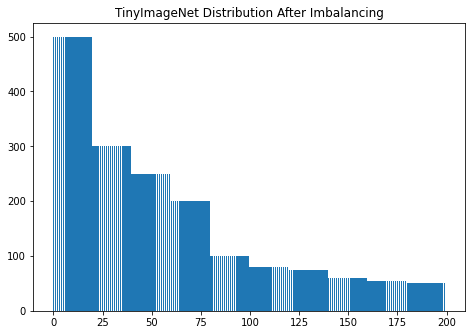

In [4]:
import matplotlib.pyplot as plt

# Sanity Check to see if Imbalancing was actually done
distribution = [0] * 200
for (x, y) in imbalanced_tinyimagenet:
  distribution[y] += 1

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
classes = [i for i in range(200)]
freqs = distribution
ax.bar(classes,freqs)
ax.set_title('TinyImageNet Distribution After Imbalancing')
plt.show()

# Loaders Code for Different Sampling Methods

In [ ]:
from random import shuffle
import numpy as np

data_by_class = {}
for (x, y) in imbalanced_tinyimagenet:
  if y not in data_by_class:
    data_by_class[y] = []

  data_by_class[y].append(x)

def GetTinyImageNetLoaders(train_dataset, test_dataset, batch_size):
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                              shuffle=False, drop_last=False)
  shuffle(train_dataset)
  current_images = torch.zeros(batch_size, 3, 64, 64)
  current_labels = torch.zeros(batch_size)
  curr_num = 0
  train_loader = []
  print(len(train_dataset))
  for (x, y) in train_dataset:
    if curr_num > batch_size - 1:
      train_loader.append((current_images, current_labels))
      current_images = torch.zeros(batch_size, 3, 64, 64)
      current_labels = torch.zeros(batch_size)
      curr_num = 0

    current_images[curr_num] = x
    current_labels[curr_num] = y
    curr_num += 1
  return train_loader, test_loader

def GetTestLoader(test_dataset, batch_size):
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                              shuffle=False, drop_last=False)
  return test_loader

def GetTinyImageNetClassBalancedBatch():
  class_ = list(np.random.randint(0, 200, batch_size))
  batch_tensor = torch.zeros(batch_size, 3, 64, 64)
  label_tensor = torch.zeros(batch_size)
  
  for i in range(batch_size):
    instance = np.random.randint(0, len(data_by_class[class_[i]]), 1)
    batch_tensor[i] = data_by_class[class_[i]][instance[0]]
    label_tensor[i] = class_[i]
  
  return (batch_tensor, label_tensor)
    

def GetTinyImageNetSquareRootBatch():
  distribution = [500] * 200
  distribution[20:40] = [300] * 20
  distribution[40:60] = [250] * 20
  distribution[60:80] = [200] * 20
  distribution[80:100] = [100] * 20
  distribution[100:120] = [80] * 20
  distribution[120:140] = [75] * 20
  distribution[140:160] = [60] * 20
  distribution[160:180] = [55] * 20
  distribution[180:200] = [50] * 20

  sqrt_dist = [distribution[i]**0.5 for i in range(len(distribution))]
  denominator = sum(sqrt_dist)
  probabilities = [sqrt_dist[i] / denominator for i in range(len(sqrt_dist))]
  class_ = list(np.random.choice(200, batch_size, p = probabilities))
  batch_tensor = torch.zeros(batch_size, 3, 64, 64)
  label_tensor = torch.zeros(batch_size)
  for i in range(batch_size):
    instance = np.random.randint(0, len(data_by_class[class_[i]]), 1)
    batch_tensor[i] = data_by_class[class_[i]][instance[0]]
    label_tensor[i] = class_[i]
  
  return (batch_tensor, label_tensor)

def GetTinyImageNetProgressiveBalancedBatch(t, T):
  p_CB = 1/200
  distribution = [500] * 200
  distribution[20:40] = [300] * 20
  distribution[40:60] = [250] * 20
  distribution[60:80] = [200] * 20
  distribution[80:100] = [100] * 20
  distribution[100:120] = [80] * 20
  distribution[120:140] = [75] * 20
  distribution[140:160] = [60] * 20
  distribution[160:180] = [55] * 20
  distribution[180:200] = [50] * 20
  denominator = sum(distribution)
  probabilities = [distribution[i] / denominator for i in range(len(distribution))]
  progressive_probs = [((1 - t/T) * probabilities[i] + t/T * p_CB) for i in range(len(probabilities))]
  class_ = list(np.random.choice(200, batch_size, p = progressive_probs))
  batch_tensor = torch.zeros(batch_size, 3, 64, 64)
  label_tensor = torch.zeros(batch_size)
  for i in range(batch_size):
    instance = np.random.randint(0, len(data_by_class[class_[i]]), 1)
    batch_tensor[i] = data_by_class[class_[i]][instance[0]]
    label_tensor[i] = class_[i]
  
  return (batch_tensor, label_tensor)

# Get Data Loaders for instance-balanced sampling (default)
train_loader, test_loader = GetTinyImageNetLoaders(imbalanced_tinyimagenet, test_dataset, 128)

# Get Data Loader for class-balanced sampling method and square root sampling and progressive-balanced
# test_loader = GetTestLoader(test_dataset, 128)

# Training Code

In [26]:

def save_model(model, file_name):
    from torch import save
    from os import path
    print("saving", file_name)
    return save(model.state_dict(), file_name)

def train_model(model_in, learning_rate = 1e-2, sampling = "instance", epochs = 25):
  # Load ResNet50 from Torchvision and modify output layer for TinyImageSet
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print(device)
  model = model_in
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
  model = model.to(device)
  loss_f = torch.nn.CrossEntropyLoss()
  # If Tau Classifier Object
  for epoch in range (epochs):
    print(epoch)
    model.train()

    # Iterate through training set, collect loss values and update model
    # Standard approach to Training
    if (sampling == "instance"):
      for im, truth_labels in train_loader:
        truth_labels = truth_labels.type(torch.LongTensor)
        im = im.to(device)
        truth_labels = truth_labels.to(device)
        predicted_labels = model(im)
        predicted_labels = predicted_labels.to(device)
        loss = loss_f(predicted_labels, truth_labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    # Different method for selecting batch using sampling method
    else:
      num_batches = len(imbalanced_tinyimagenet) // batch_size
      for i in range(num_batches):
        if (sampling == "class"):
          im, truth_labels = GetTinyImageNetClassBalancedBatch()
        elif (sampling == "sqrt"):
          im, truth_labels = GetTinyImageNetSquareRootBatch()
        elif (sampling == "progressive"):
          im, truth_labels = GetTinyImageNetProgressiveBalancedBatch(t = min(epoch * 2, epochs), T = epochs)
        truth_labels = truth_labels.type(torch.LongTensor)
        im = im.to(device)
        truth_labels = truth_labels.to(device)
        predicted_labels = model(im)
        predicted_labels = predicted_labels.to(device)
        loss = loss_f(predicted_labels, truth_labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
 
    if epoch % 5 == 0:
      if isinstance(model, TauClassifier):
        print("Norm Tau Weights")
        model.tau_norm(0.7)
      model.eval()
      accuracies = []
      for validation_im, validation_labels in test_loader:
        validation_im = validation_im.to(device)
        validation_labels = validation_labels.to(device)

        predicted_labels = model(validation_im).argmax(1)
        accuracy = (predicted_labels == validation_labels).float().mean().item()
        accuracies.append(accuracy)
      
      validation_set_accuracy = torch.FloatTensor(accuracies).mean().item()
      print("Epoch: ", epoch, "Test Accuracy : ", validation_set_accuracy)
      # save_model(model, 'det' + str(epoch) + sampling + '.th')

  for validation_im, validation_labels in test_loader:
      validation_im = validation_im.to(device)
      validation_labels = validation_labels.to(device)

      predicted_labels = model(validation_im).argmax(1)
      accuracy = (predicted_labels == validation_labels).float().mean().item()
      accuracies.append(accuracy)
    
  validation_set_accuracy = torch.FloatTensor(accuracies).mean().item()
  print("Final Test Accuracy : ", validation_set_accuracy)

# Joint Classifier Model Architecture

In [11]:
import torch
import torchvision
import torchvision.transforms as transforms

class JointClassifier(torch.nn.Module):
    def __init__(self, im_dim, num_class):
        super().__init__()
        self.backbone_nn = torchvision.models.resnext50_32x4d(pretrained=True, progress=True)
        self.backbone_nn.fc = torch.nn.Linear(in_features=2048, out_features = 3 * im_dim * im_dim)
        self.weights = torch.nn.Parameter(torch.ones(3 * im_dim * im_dim, num_class))
        self.biases = torch.nn.Parameter(torch.ones(num_class))

    def forward(self, x):
        feature_representation = self.backbone_nn(x)
        return feature_representation.matmul(self.weights) + self.biases
      

# Decoupled Classifier Model Architecture

In [27]:
import torch
import torchvision
import torchvision.transforms as transforms

class CRTClassifier(torch.nn.Module):
    def __init__(self, im_dim = 32, num_class = 10, sampling = "instance"):
        super().__init__()
        model = JointClassifier(im_dim, num_class)
        model.load_state_dict(torch.load('det_' + sampling + '.th', map_location='cpu'))
        self.backbone_nn = model.backbone_nn
        for param in self.backbone_nn.parameters():
            param.requires_grad = False
        self.linear_layer = torch.nn.Linear(3 * im_dim * im_dim, num_class)

    def forward(self, x):
        feature_representation = self.backbone_nn(x)
        return self.linear_layer(feature_representation)

class TauClassifier(torch.nn.Module):
    def __init__(self, im_dim = 32, num_class = 10, sampling = "instance"):
        super().__init__()
        model = JointClassifier(im_dim, num_class)
        model.load_state_dict(torch.load('det_' + sampling + '.th', map_location='cpu'))
        self.backbone_nn = model.backbone_nn
        for param in self.backbone_nn.parameters():
            param.requires_grad = False
        self.weights = torch.nn.Parameter(torch.ones(3 * im_dim * im_dim, num_class))

    def tau_norm(self, tau):
        for j in range(self.weights.size(1)):
          self.weights.data[:, j]  = self.weights[:, j] / ((self.weights[:, j].norm())**tau)

    def forward(self, x):
        feature_representation = self.backbone_nn(x)
        return feature_representation.matmul(self.weights)

# Test out Joint Training Method for Different Sampling Methods

In [ ]:
# 30 Epochs For Joint Training
joint_classifier = JointClassifier(64, 200)
batch_size = 128
# To test Instance-balanced sampling - 0.1775
# train_model(joint_classifier, learning_rate = 1e-3, sampling = "instance", epochs = 5)

# To test Class-balanced sampling - 0.1799
# train_model(joint_classifier, learning_rate = 1e-3, sampling = "class", epochs = 5)

# To Test Square Root Sampling - 0.1904
# train_model(joint_classifier, learning_rate = 1e-3, sampling = "sqrt", epochs = 5)

# To Test Progressively-Balanced Sampling - 0.1844
# train_model(joint_classifier, learning_rate = 1e-3, sampling = "progressive", epochs = 5)

# Test out Decoupling Method with cRT Classifier

In [ ]:
# Adjust Sampling Argument to name of Sampling Strategy used to Learn Representations
crt_classifier = CRTClassifier(64, 200, sampling = "")

# Instance-balanced for crt - 0.2918
# train_model(crt_classifier, learning_rate = 1e-3, sampling = "instance", epochs = 5)

# Class-balanced for crt - 0.2770
# train_model(crt_classifier, learning_rate = 1e-3, sampling = "class", epochs = 5)

# Sqrt Sampling for crt - 0.2861
# train_model(crt_classifier, learning_rate = 1e-3, sampling = "sqrt", epochs = 5)

# Progressively balanced for crt - 0.2830
# train_model(crt_classifier, learning_rate = 1e-3, sampling = "progressive", epochs = 5)

# Test out Decoupling Method with Tau-Norm Classifier

In [ ]:
# Adjust Sampling Argument to name of Sampling Strategy used to Learn Representations
tau_classifier = TauClassifier(64, 200, sampling = "")

# Instance-balanced for tau - 0.2816
# train_model(tau_classifier, learning_rate = 1e-3, sampling = "instance", epochs = 5)

# Class-balanced for tau - 0.2852
# train_model(tau_classifier, learning_rate = 1e-3, sampling = "class", epochs = 5)

# Sqrt Sampling for tau - 0.2746
# train_model(tau_classifier, learning_rate = 1e-3, sampling = "sqrt", epochs = 5)

# Progressive-balanced for tau - 0.2722
# train_model(tau_classifier, learning_rate = 1e-3, sampling = "progressive", epochs = 5)

# Joint Classifer Draw Diagrams - Display Results

In [7]:
!pip install tabulate

In [8]:
from tabulate import tabulate

# Joint Training Approach Results
# Batch size = 128, learning rate = 1e-3, epochs = 5, ResNeXT Backbone Network
table = [['Joint Training', 'Top-1 Accuracy'], ['Instance-balanced', 0.1875], 
         ['Class-balanced', 0.1799], ['Square-Root', 0.1904], ['Progressively-balanced', 0.1844]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒════════════════════════╤══════════════════╕
│ Joint Training         │   Top-1 Accuracy │
╞════════════════════════╪══════════════════╡
│ Instance-balanced      │           0.1875 │
├────────────────────────┼──────────────────┤
│ Class-balanced         │           0.1799 │
├────────────────────────┼──────────────────┤
│ Square-Root            │           0.1904 │
├────────────────────────┼──────────────────┤
│ Progressively-balanced │           0.1844 │
╘════════════════════════╧══════════════════╛


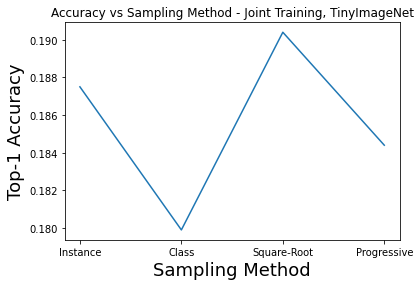

In [31]:
import matplotlib.pyplot as plt

learning_rate = ["Instance", "Class", "Square-Root", "Progressive"]
final_test_accuracies = [0.1875, 0.1799, 0.1904, 0.1844]

axes = plt.gca()
plt.plot(learning_rate, final_test_accuracies)
plt.title("Accuracy vs Sampling Method - Joint Training, TinyImageNet")
plt.xlabel('Sampling Method', fontsize = 18)
plt.ylabel('Top-1 Accuracy', fontsize = 18)
plt.show()

# Decoupling Methods Draw Diagrams - Display Results

In [25]:
# cRT Training Approach Results
# Batch size = 128, learning rate = 1e-3, epochs = 5, ResNeXT Backbone Network
table = [['cRT', 'Top-1 Accuracy'], ['Instance-balanced', 0.2918], 
         ['Class-balanced', 0.2770], ['Square-Root', 0.2861], ['Progressively-balanced', 0.2830]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒════════════════════════╤══════════════════╕
│ cRT                    │   Top-1 Accuracy │
╞════════════════════════╪══════════════════╡
│ Instance-balanced      │           0.2918 │
├────────────────────────┼──────────────────┤
│ Class-balanced         │           0.277  │
├────────────────────────┼──────────────────┤
│ Square-Root            │           0.2861 │
├────────────────────────┼──────────────────┤
│ Progressively-balanced │           0.283  │
╘════════════════════════╧══════════════════╛


In [32]:
# Tau-Norm Training Approach Results
# Batch size = 128, learning rate = 1e-3, epochs = 5, ResNeXT Backbone Network
table = [['Tau-Norm', 'Top-1 Accuracy'], ['Instance-balanced', 0.2816], 
         ['Class-balanced', 0.2852], ['Square-Root', 0.2746], ['Progressively-balanced', 0.2722]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒════════════════════════╤══════════════════╕
│ Tau-Norm               │   Top-1 Accuracy │
╞════════════════════════╪══════════════════╡
│ Instance-balanced      │           0.2816 │
├────────────────────────┼──────────────────┤
│ Class-balanced         │           0.2852 │
├────────────────────────┼──────────────────┤
│ Square-Root            │           0.2746 │
├────────────────────────┼──────────────────┤
│ Progressively-balanced │           0.2722 │
╘════════════════════════╧══════════════════╛


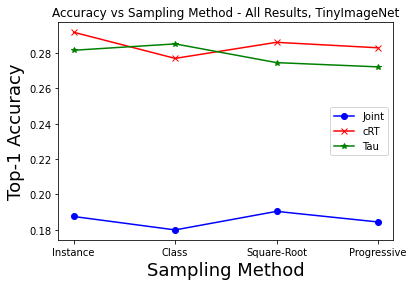

In [34]:
sampling_method = ["Instance", "Class", "Square-Root", "Progressive"]
joint_test_accuracies = [0.1875, 0.1799, 0.1904, 0.1844]
cRT_test_accuracies = [0.2918, 0.277, 0.2861, 0.283]
tau_norm_accuracies = [0.2816, 0.2852, 0.2746, 0.2722]

axes = plt.gca()
plt.plot(sampling_method, joint_test_accuracies, '-bo')
plt.plot(sampling_method, cRT_test_accuracies, '-rx')
plt.plot(sampling_method, tau_norm_accuracies, '-g*')
plt.title("Accuracy vs Sampling Method - All Results, TinyImageNet")
plt.xlabel('Sampling Method', fontsize = 18)
plt.ylabel('Top-1 Accuracy', fontsize = 18)
plt.legend(["Joint", "cRT", "Tau"])
plt.show()